# shp

> Spatially Homogenious Pixels Identification

In [ ]:
#| default_exp cli/shp

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
from matplotlib import pyplot as plt
import zarr
import colorcet
import moraine.cli as mc
from moraine.utils_ import is_cuda_available

In [ ]:
#| export
from itertools import product
import math
import logging
import time

import zarr
import numcodecs
import numpy as np

import dask
from dask import array as da
from dask import delayed
from dask.distributed import Client, LocalCluster, progress
from moraine.utils_ import is_cuda_available, get_array_module
if is_cuda_available():
    import cupy as cp
    from dask_cuda import LocalCUDACluster
    from rmm.allocators.cupy import rmm_cupy_allocator
import moraine as mr
from moraine.cli.logging import mc_logger
from moraine.cli import dask_from_zarr,dask_from_zarr_overlap, dask_to_zarr

In [ ]:
#| export
@mc_logger
def shp_test(
    rslc:str, # input: rslc stack
    pvalue:str, # output: the p value of the test
    az_half_win:int, # azimuth half window size
    r_half_win:int, # range half window size
    method:str=None, # SHP identification method,optional. Default: ks
    chunks:tuple[int,int]=None, # chunk size, optional. Default: the chunk size in rslc
    cuda:bool=False, # if use cuda for processing, false by default
    processes=None, # use process for dask worker over thread, the default is False for cpu, only applied if cuda==False
    n_workers=None, # number of dask worker, the default is 1 for cpu, number of GPU for cuda
    threads_per_worker=None, # number of threads per dask worker, the default is 2 for cpu, only applied if cuda==False
    rmm_pool_size=0.9, # set the rmm pool size, only applied when cuda==True
    **dask_cluster_arg, # other dask local/cudalocal cluster args
):
    '''SHP identification through hypothetic test.'''
    rslc_path = rslc
    pvalue_path = pvalue

    logger = logging.getLogger(__name__)
    if not method: method = 'ks'
    logger.info(f'hypothetic test method: {method}')
    if method != 'ks':
        logger.warning('Currently only KS test is implented. Switching to it.')
        method = 'ks'

    rslc_zarr = zarr.open(rslc_path,mode='r')
    logger.zarr_info(rslc_path,rslc_zarr)

    assert rslc_zarr.ndim == 3, " rslcs dimentation is not 3."
    
    if chunks is None: chunks = rslc_zarr.chunks[:2]
    chunks=(*chunks,*rslc_zarr.shape[2:])
    if cuda:
        Cluster = LocalCUDACluster; cluster_args= {
            'n_workers':n_workers,
            'rmm_pool_size':rmm_pool_size}
        cluster_args.update(dask_cluster_arg)
        xp = cp
    else:
        if processes is None: processes = False
        if n_workers is None: n_workers = 1
        if threads_per_worker is None: threads_per_worker = 1
        Cluster = LocalCluster; cluster_args = {'processes':processes, 'n_workers':n_workers, 'threads_per_worker':threads_per_worker}
        cluster_args.update(dask_cluster_arg)
        xp = np

    logger.info('starting dask local cluster.')
    with Cluster(**cluster_args) as cluster, Client(cluster) as client:
        logger.info('dask local cluster started.')
        logger.dask_cluster_info(cluster)
        if cuda: client.run(cp.cuda.set_allocator, rmm_cupy_allocator)

        az_win = 2*az_half_win+1
        logger.info(f'azimuth half window size: {az_half_win}; azimuth window size: {az_win}')
        r_win = 2*r_half_win+1
        logger.info(f'range half window size: {r_half_win}; range window size: {r_win}')
        depth = (az_half_win, r_half_win, 0); boundary = {0:'none',1:'none',2:'none'}

        cpu_rslc_overlap = dask_from_zarr_overlap(rslc_path,chunks=chunks,depth=depth)
        logger.darr_info('rslc with overlap', cpu_rslc_overlap)

        if cuda:
            rslc_overlap = cpu_rslc_overlap.map_blocks(xp.asarray)
        else:
            rslc_overlap = cpu_rslc_overlap
        rmli_overlap = rslc_overlap.map_blocks(mr.rslc2amp)
        p_chunks = (*rmli_overlap.chunks[:2],(az_win,),(r_win,))
        logger.info('applying test on rmli stack.')
        p = rmli_overlap.map_blocks(mr.ks_test,az_half_win=az_half_win,r_half_win=r_half_win,
                                    new_axis=-1,chunks=p_chunks,meta=xp.array((),dtype=rmli_overlap.dtype))
        logger.info('trim shared boundaries between p value chunks')
        p = da.overlap.trim_overlap(p,depth=depth,boundary=boundary)
        if cuda:
            cpu_p = p.map_blocks(xp.asnumpy)
        else:
            cpu_p = p
        logger.darr_info('p value', cpu_p)

        logger.info('saving p value.')
        _p = dask_to_zarr(cpu_p,pvalue_path,chunks=(*cpu_p.chunksize[:2],1,1))
        # _p = da.to_zarr(cpu_p,pvalue_path,compute=False,overwrite=True)
        # p_zarr = kvikio.zarr.open_cupy_array(pvalue_path,'w',shape=p.shape, chunks=p.chunksize, dtype=p.dtype,compressor=None)
        # _p = da.store(p,p_zarr,compute=False,lock=False)

        logger.info('computing graph setted. doing all the computing.')
        #_p.visualize(filename='_p.svg',color='order',cmap="autumn",optimize_graph=True)
        futures = client.persist(_p)
        
        progress(futures,notebook=False)
        time.sleep(0.1)
        da.compute(futures)
        logger.info('computing finished.')
    logger.info('dask cluster closed.')

This function is a wrapper of functions in `decorrelation.shp` that provides file interface. Please refer it for the usage. It utilizes dask for parallel and distributed computation. Compared with the functions in `decorrelation.shp`, this function splits the dataset into several chunks and the computation in these chunks can run in parallel on multi-GPUs.

The `r_chunk_size` and `az_chunk_size` is used to determine how many pixels in range and azimuth in one chunk. The chunk size of the output pvalue is also setted according to them.

In [ ]:
rslc = './raw/rslc.zarr'
pvalue = './shp/pvalue.zarr'

In [ ]:
logger = mc.get_logger()

In [ ]:
%%time
shp_test(rslc,pvalue,az_half_win=5,r_half_win=5,method=None)

2025-09-18 12:36:38 - log_args - INFO - running function: shp_test
2025-09-18 12:36:38 - log_args - INFO - fetching args:
2025-09-18 12:36:38 - log_args - INFO - rslc = './raw/rslc.zarr'
2025-09-18 12:36:38 - log_args - INFO - pvalue = './shp/pvalue.zarr'
2025-09-18 12:36:38 - log_args - INFO - az_half_win = 5
2025-09-18 12:36:38 - log_args - INFO - r_half_win = 5
2025-09-18 12:36:38 - log_args - INFO - method = None
2025-09-18 12:36:38 - log_args - INFO - chunks = None
2025-09-18 12:36:38 - log_args - INFO - cuda = False
2025-09-18 12:36:38 - log_args - INFO - processes = None
2025-09-18 12:36:38 - log_args - INFO - n_workers = None
2025-09-18 12:36:38 - log_args - INFO - threads_per_worker = None
2025-09-18 12:36:38 - log_args - INFO - rmm_pool_size = 0.9
2025-09-18 12:36:38 - log_args - INFO - dask_cluster_arg = {}
2025-09-18 12:36:38 - log_args - INFO - fetching args done.
2025-09-18 12:36:38 - shp_test - INFO - hypothetic test method: ks
2025-09-18 12:36:38 - zarr_info - INFO - ./

In [ ]:
%%time
if is_cuda_available():
    shp_test(rslc,pvalue,az_half_win=5,r_half_win=5,cuda=True)

2025-09-18 12:36:58 - log_args - INFO - running function: shp_test
2025-09-18 12:36:58 - log_args - INFO - fetching args:
2025-09-18 12:36:58 - log_args - INFO - rslc = './raw/rslc.zarr'
2025-09-18 12:36:58 - log_args - INFO - pvalue = './shp/pvalue.zarr'
2025-09-18 12:36:58 - log_args - INFO - az_half_win = 5
2025-09-18 12:36:58 - log_args - INFO - r_half_win = 5
2025-09-18 12:36:58 - log_args - INFO - method = None
2025-09-18 12:36:58 - log_args - INFO - chunks = None
2025-09-18 12:36:58 - log_args - INFO - cuda = True
2025-09-18 12:36:58 - log_args - INFO - processes = None
2025-09-18 12:36:58 - log_args - INFO - n_workers = None
2025-09-18 12:36:58 - log_args - INFO - threads_per_worker = None
2025-09-18 12:36:58 - log_args - INFO - rmm_pool_size = 0.9
2025-09-18 12:36:58 - log_args - INFO - dask_cluster_arg = {}
2025-09-18 12:36:58 - log_args - INFO - fetching args done.
2025-09-18 12:36:58 - shp_test - INFO - hypothetic test method: ks
2025-09-18 12:36:58 - zarr_info - INFO - ./r

2025-09-18 12:37:00,433 - distributed.worker - WARNING - Setting CPU affinity for GPU failed. Please refer to the following link for troubleshooting information: https://docs.rapids.ai/api/dask-cuda/nightly/troubleshooting/#setting-cpu-affinity-failure
2025-09-18 12:37:00,437 - distributed.worker - WARNING - Setting CPU affinity for GPU failed. Please refer to the following link for troubleshooting information: https://docs.rapids.ai/api/dask-cuda/nightly/troubleshooting/#setting-cpu-affinity-failure


2025-09-18 12:37:00 - shp_test - INFO - dask local cluster started.
2025-09-18 12:37:00 - dask_cluster_info - INFO - dask cluster: LocalCUDACluster(dashboard_link='http://127.0.0.1:8787/status', workers=2, threads=2, memory=256.00 GiB)
2025-09-18 12:37:00 - shp_test - INFO - azimuth half window size: 5; azimuth window size: 11
2025-09-18 12:37:00 - shp_test - INFO - range half window size: 5; range window size: 11
2025-09-18 12:37:00 - darr_info - INFO - rslc with overlap dask array shape, chunksize, dtype: (2520, 1844, 17), (1010, 1005, 17), complex64
2025-09-18 12:37:01 - shp_test - INFO - applying test on rmli stack.
2025-09-18 12:37:01 - shp_test - INFO - trim shared boundaries between p value chunks
2025-09-18 12:37:01 - darr_info - INFO - p value dask array shape, chunksize, dtype: (2500, 1834, 11, 11), (1000, 1000, 11, 11), float32
2025-09-18 12:37:01 - shp_test - INFO - saving p value.
2025-09-18 12:37:01 - zarr_info - INFO - ./shp/pvalue.zarr zarray shape, chunks, dtype: (2500

In [ ]:
#| export
@mc_logger
def select_shp(
    pvalue:str, # input: pvalue of hypothetic test
    is_shp:str, # output: bool array indicating the SHPs
    shp_num:str, # output: integer array indicating number of SHPs
    p_max:float=0.05, # threshold of p value to select SHP,optional. Default: 0.05
    chunks:tuple[int,int]=None, # chunk size, optional. Default: the chunk size in rslc
    processes=False, # use process for dask worker over thread, the default is False
    n_workers=1, # number of dask worker, the default is 1
    threads_per_worker=1, # number of threads per dask worker
    **dask_cluster_arg, # other dask local cluster args
):
    '''
    Select SHP based on pvalue of SHP test.
    '''
    is_shp_path = is_shp
    shp_num_path = shp_num
    logger = logging.getLogger(__name__)

    p_zarr = zarr.open(pvalue,mode='r'); logger.zarr_info(pvalue, p_zarr)
    assert p_zarr.ndim == 4, " pvalue dimentation is not 4."

    if chunks is None: chunks = p_zarr.chunks[:2]
    chunks=(*chunks,*p_zarr.shape[2:])

    logger.info('starting dask cluster.')
    with LocalCluster(processes=processes,n_workers=n_workers,threads_per_worker=threads_per_worker,**dask_cluster_arg) as cluster, Client(cluster) as client:
        logger.info('dask cluster started.')
        logger.dask_cluster_info(cluster)

        p = dask_from_zarr(pvalue,chunks=chunks)
        logger.darr_info('pvalue', p)
        p_delayed = p.to_delayed()
        is_shp_delayed = np.empty_like(p_delayed,dtype=object)
        shp_num_delayed = np.empty_like(p_delayed, dtype=object)

        with np.nditer(p_delayed,flags=['multi_index','refs_ok'], op_flags=['readwrite']) as p_it:
            for p_block in p_it:
                idx = p_it.multi_index
                is_shp_delayed[idx], shp_num_delayed[idx] = delayed(mr.select_shp,pure=True,nout=2)(p_delayed[idx],p_max)
                chunk_shape = p.blocks[idx].shape[:-2]
                is_shp_delayed[idx] = da.from_delayed(is_shp_delayed[idx], shape = (*chunk_shape, *p.shape[2:]), meta = np.array((),dtype=np.bool_))
                shp_num_delayed[idx] = da.from_delayed(shp_num_delayed[idx], shape=chunk_shape, meta = np.array((),dtype=np.int32))
        is_shp = da.block(is_shp_delayed.tolist())
        shp_num = da.block(shp_num_delayed[:,:,0,0].tolist())
        logger.info('selecting SHPs based on pvalue threshold: '+str(p_max))
        logger.darr_info('is_shp', is_shp)

        logger.info('calculate shp_num.')
        logger.darr_info('shp_num',shp_num)

        logger.info('saving is_shp.')
        _is_shp = dask_to_zarr(is_shp, is_shp_path, chunks=(*is_shp.chunksize[0:2],1,1))

        logger.info('saving shp_num.')
        _shp_num = dask_to_zarr(shp_num, shp_num_path, chunks=is_shp.chunksize[0:2])
        logger.info('computing graph setted. doing all the computing.')

        futures = client.persist([_is_shp,_shp_num])
        progress(futures,notebook=False); time.sleep(0.1)
        da.compute(futures)
        logger.info('computing finished.')
    logger.info('dask cluster closed.')

In [ ]:
pvalue = './shp/pvalue.zarr'
is_shp = './shp/is_shp.zarr'
shp_num = './shp/num.zarr'
p_max = 0.05

In [ ]:
%%time
select_shp(pvalue,is_shp,shp_num,p_max=p_max)

2025-09-18 12:37:09 - log_args - INFO - running function: select_shp
2025-09-18 12:37:09 - log_args - INFO - fetching args:
2025-09-18 12:37:09 - log_args - INFO - pvalue = './shp/pvalue.zarr'
2025-09-18 12:37:09 - log_args - INFO - is_shp = './shp/is_shp.zarr'
2025-09-18 12:37:09 - log_args - INFO - shp_num = './shp/num.zarr'
2025-09-18 12:37:09 - log_args - INFO - p_max = 0.05
2025-09-18 12:37:09 - log_args - INFO - chunks = None
2025-09-18 12:37:09 - log_args - INFO - processes = False
2025-09-18 12:37:09 - log_args - INFO - n_workers = 1
2025-09-18 12:37:09 - log_args - INFO - threads_per_worker = 1
2025-09-18 12:37:09 - log_args - INFO - dask_cluster_arg = {}
2025-09-18 12:37:09 - log_args - INFO - fetching args done.
2025-09-18 12:37:09 - zarr_info - INFO - ./shp/pvalue.zarr zarray shape, chunks, dtype: (2500, 1834, 11, 11), (1000, 1000, 1, 1), float32
2025-09-18 12:37:09 - select_shp - INFO - starting dask cluster.
2025-09-18 12:37:09 - select_shp - INFO - dask cluster started.


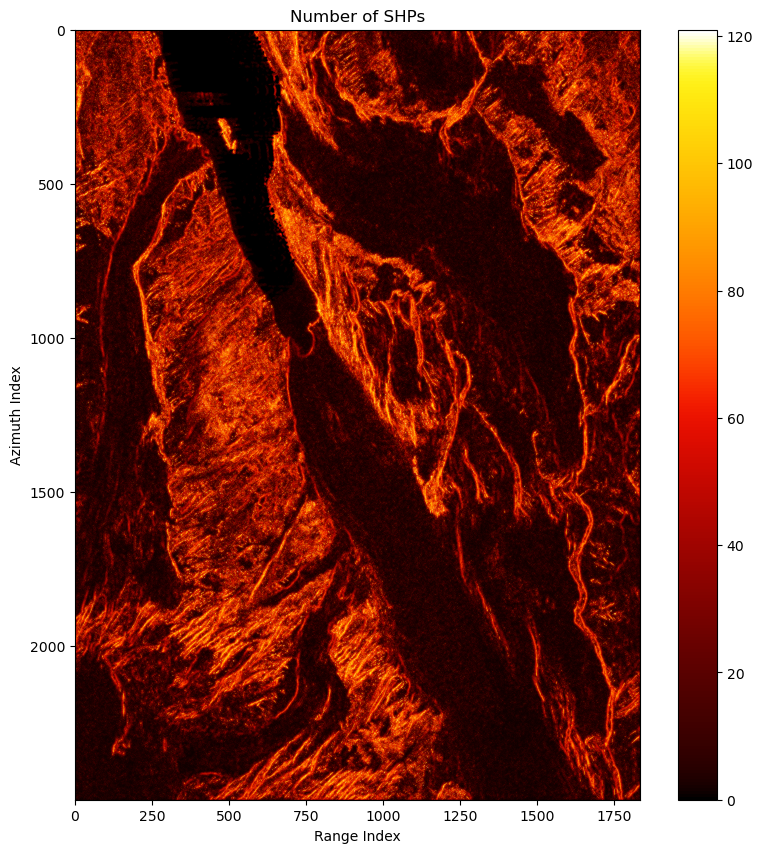

In [ ]:
shp_num_zarr = zarr.open(shp_num,mode='r')
fig, ax = plt.subplots(1,1,figsize=(10,10))
pcm = ax.imshow(shp_num_zarr[:],cmap=colorcet.cm.fire)
ax.set(title='Number of SHPs',xlabel='Range Index',ylabel='Azimuth Index')
fig.colorbar(pcm)
fig.show()

Then we can select DS candidates based on number of SHPs and slice is_shp only on DS candidates.

In [ ]:
ds_can_gix = './shp/ds_can_gix.zarr'
is_ds_can= './shp/is_ds_can.zarr'

In [ ]:
mc.pc_logic_ras(shp_num,ds_can_gix,'ras>=50')

2025-09-18 12:37:19 - log_args - INFO - running function: pc_logic_ras
2025-09-18 12:37:19 - log_args - INFO - fetching args:
2025-09-18 12:37:19 - log_args - INFO - ras = './shp/num.zarr'
2025-09-18 12:37:19 - log_args - INFO - gix = './shp/ds_can_gix.zarr'
2025-09-18 12:37:19 - log_args - INFO - operation = 'ras>=50'
2025-09-18 12:37:19 - log_args - INFO - chunks = 100000
2025-09-18 12:37:19 - log_args - INFO - fetching args done.
2025-09-18 12:37:19 - zarr_info - INFO - ./shp/num.zarr zarray shape, chunks, dtype: (2500, 1834), (1000, 1000), int32
2025-09-18 12:37:19 - pc_logic_ras - INFO - loading ras into memory.
2025-09-18 12:37:19 - pc_logic_ras - INFO - select pc based on operation: ras>=50
2025-09-18 12:37:19 - pc_logic_ras - INFO - number of selected pixels: 732727.
2025-09-18 12:37:19 - zarr_info - INFO - ./shp/ds_can_gix.zarr zarray shape, chunks, dtype: (732727, 2), (100000, 1), int32
2025-09-18 12:37:19 - pc_logic_ras - INFO - writing gix.
2025-09-18 12:37:19 - pc_logic_ra

In [ ]:
mc.gix2bool(ds_can_gix, is_ds_can, shape= shp_num_zarr.shape)

2025-09-18 12:37:19 - log_args - INFO - running function: gix2bool
2025-09-18 12:37:19 - log_args - INFO - fetching args:
2025-09-18 12:37:19 - log_args - INFO - gix = './shp/ds_can_gix.zarr'
2025-09-18 12:37:19 - log_args - INFO - is_pc = './shp/is_ds_can.zarr'
2025-09-18 12:37:19 - log_args - INFO - shape = (2500, 1834)
2025-09-18 12:37:19 - log_args - INFO - chunks = (1000, 1000)
2025-09-18 12:37:19 - log_args - INFO - fetching args done.
2025-09-18 12:37:19 - zarr_info - INFO - gix zarray shape, chunks, dtype: (732727, 2), (100000, 1), int32
2025-09-18 12:37:19 - gix2bool - INFO - loading gix into memory.
2025-09-18 12:37:19 - gix2bool - INFO - calculate the bool array
2025-09-18 12:37:19 - zarr_info - INFO - is_pc zarray shape, chunks, dtype: (2500, 1834), (1000, 1000), bool
2025-09-18 12:37:19 - gix2bool - INFO - write the bool array.
2025-09-18 12:37:19 - gix2bool - INFO - write done.


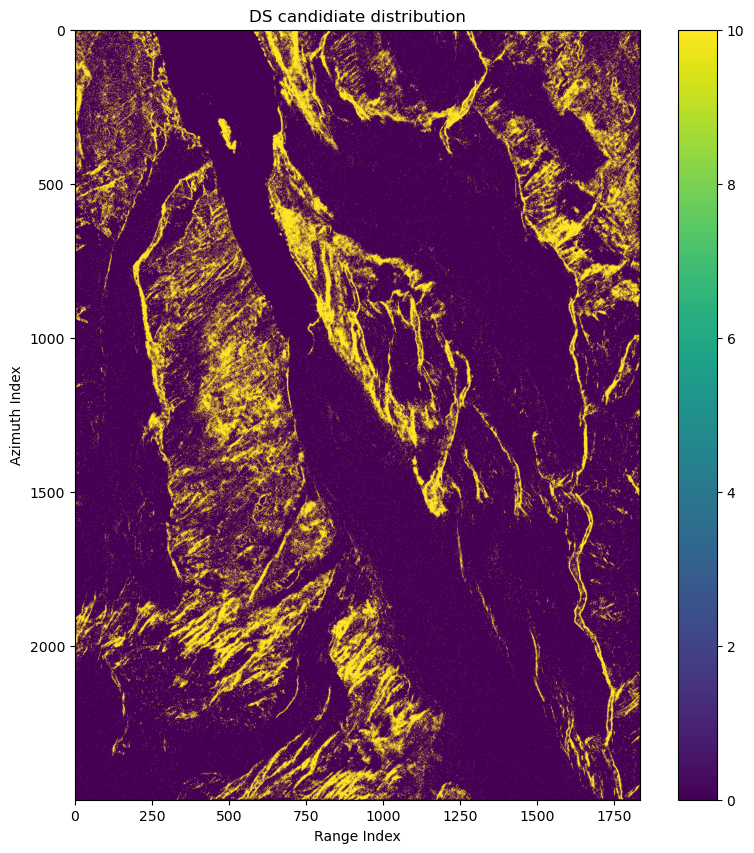

In [ ]:
is_ds_can_zarr = zarr.open(is_ds_can,mode='r')
fig, ax = plt.subplots(1,1,figsize=(10,10))
pcm = ax.imshow(is_ds_can_zarr[:].astype(np.float32)*10)
ax.set(title='DS candidiate distribution',xlabel='Range Index',ylabel='Azimuth Index')
fig.colorbar(pcm)
fig.show()

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()